In [11]:
%autoreload 2
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random
from tqdm import tqdm

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteMap, FiniteVec, inner, SpVec, CombVec, RolloutSp, RolloutIdx, CovOp, CrossCovOp, CombVec
from jaxrk.kern import (GaussianKernel, LaplaceKernel, SplitDimsKernel, PeriodicKernel, LinearKernel, SpikeKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from jaxrk.reduce import SparseReduce, LinearReduce, BlockReduce
from jaxrk.kern import median_heuristic
from sklearn.datasets import make_moons
from copy import copy
from data import Traffic


traf = Traffic()

idx_out = 40
n = 20
use_inner = "gen_gauss"

traf.data['train'] = Traffic.equalize_smp_size(traf.data['train']).values.reshape(-1, 144, traf.data['test'].shape[-1])
traf.data['test'] = traf.data['test'].values.reshape(-1, 144, traf.data['test'].shape[-1])

In [12]:
max_dim = 2
def add_dimension_index (d):
    idx, dat = np.repeat(d[:, :, :2], d.shape[-1] - 2, axis = 1), d[:, :, 2:].reshape((d.shape[0], -1))
    dim_idx = np.repeat(np.tile(np.arange(d.shape[-1] - 2), d.shape[1]).reshape((1, -1, 1)), d.shape[0], axis=0)
    tme_dim_idx = np.concatenate((idx, dim_idx), -1)
    return tme_dim_idx, dat


train_idx, train_d = add_dimension_index(traf.data['train'][:10,:, :(2+max_dim)])

train_inp = np.vstack(np.concatenate((train_idx[:, :-1, 1:], train_d[:,:-1, np.newaxis]), -1))
train_inp_idx = np.vstack(train_idx[:, 1:, 1:])
train_out = train_d[:, 1:].flatten()[:, np.newaxis]

num_points_per_obs = train_d.shape[1] - 1

In [13]:
train_idx.shape, train_d.shape, train_inp.shape, train_inp_idx.shape

((10, 288, 3), (10, 288), (2870, 3), (2870, 2))

In [14]:
use_combined = True
#(train_inp, train_inp_idx, train_out) = (traf.data['train'][:idx_out, :-1, 1:3].reshape((-1, 2)),
#                                         traf.data['train'][:idx_out, 1:, 1:2].reshape((-1, 1)),
#                                         traf.data['train'][:idx_out, 1:, 2:3].reshape((-1, 1)))
un, cts, sr = SparseReduce.sum_from_unique(train_out.flatten(), mean=True)

In [32]:
obs_median = 0.84 #0.9 #median_heuristic(traf.data['train'][:14, :-1, 2].reshape((-1, 1)), "sqeuclidean")
idx_median = 80 #1e+5 #median_heuristic(traf.data['train'][:14, :-1, 1:2].reshape((-1, 1)), "sqeuclidean")
print(obs_median, idx_median)

out_kern = LaplaceKernel(obs_median)
period = train_inp_idx.max(0)
idx_kern = SplitDimsKernel([0, 1, 2], [PeriodicKernel(period[0], 1), SpikeKernel(1, 0.7)])
gauss_idx_kern = LaplaceKernel(idx_median)
#idx_kern = GaussianKernel(idx_median)
in_kern = SplitDimsKernel([0, 1, 2], [idx_kern, out_kern])

downweight_second_add = lambda x,y: x+y

#

out_vec_gr = FiniteVec(out_kern, un[:, np.newaxis],)

#

out_vec = FiniteVec(out_kern, train_out)

if not use_combined:
    inp_vec = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner)
    inp_vec_gr = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner, reduce = [sr])
else:
    inp_vec = CombVec(SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner), FiniteVec(gauss_idx_kern, train_inp_idx), downweight_second_add)
    inp_vec_gr = CombVec(SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner), FiniteVec(gauss_idx_kern, train_inp_idx), downweight_second_add, reduce = [sr])
print(len(inp_vec), len(inp_vec_gr))
ir = RolloutIdx(train_inp_idx, example = train_inp_idx)

0.84 80


/Users/ischuster/opt/anaconda3/lib/python3.7/site-packages/jax/_src/lax/lax.py:6126: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


2870 10


In [33]:
e = 0.24*2 #e = 2*b
ei = 1./e
c = 0.9

In [38]:
O = Cmo(inp_vec, out_vec, 1./cts.sum()**(e*c), center = False)
test_inp = traf.data['test'][:1, :n, 1:3].reshape((-1, 2))
#test_inp[:, 1:] = stats.norm.ppf(to.cdf(test_inp[:, 1:]))
test_out = traf.data['test'][:1, n:, 2:3]
#test_out = stats.norm.ppf(to.cdf(traf.data['train'][idx_out, n:, 2:3]))


#test_inp_idx = np.vstack(test_idx[:, 1:, 1:])
#test_out = test_d[:, 1:].flatten()[:, np.newaxis]



/Users/ischuster/opt/anaconda3/lib/python3.7/site-packages/jax/_src/lax/lax.py:6126: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [39]:
test_idx, test_d = add_dimension_index(traf.data['test'][:1,:, :(2+max_dim)])

test_inp_full = np.vstack(np.concatenate((test_idx[:, :-1, 1:], test_d[:,:-1, np.newaxis]), -1))
test_inp = test_inp_full[:n*max_dim]
inp_test = SpVec(in_kern, test_inp, np.array([test_inp.shape[0]]), use_subtrajectories = False, use_inner=use_inner)

ir.current = test_inp[-1, :-1]
len(test_inp)

40

In [40]:
cur_ro = RolloutSp(O, inp_test, max_dim + 1, ir)
rval = []
rval_idx = []
for i, idx in tqdm(enumerate(ir)):
    new_point = cur_ro.get_embedding().point_representant()
    rval.append(new_point)
    rval_idx.append(idx)
    cur_ro.update(new_point, idx)
    if i > 122*max_dim:
        break
rval_idx = np.array(rval_idx)
rval = np.array(rval)[:-2].reshape((-1, max_dim))

/Users/ischuster/opt/anaconda3/lib/python3.7/site-packages/jax/_src/lax/lax.py:6126: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



0it [00:00, ?it/s]/Users/ischuster/opt/anaconda3/lib/python3.7/site-packages/jax/_src/lax/lax.py:6126: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



1it [00:00,  1.47it/s]


2it [00:01,  1.48it

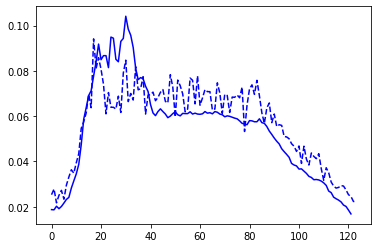

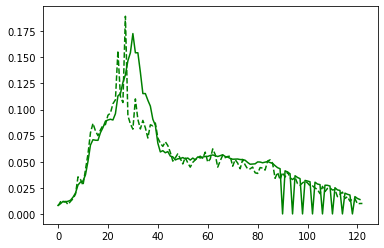

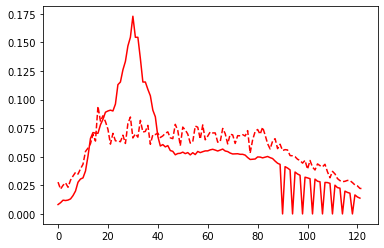

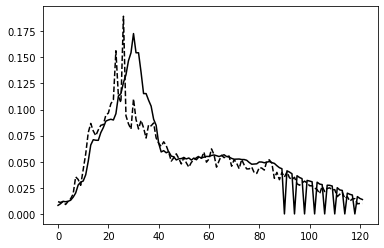

<Figure size 432x288 with 0 Axes>

In [41]:
#index and history input
start = n*max_dim
for dim, color in [(0, "b"), (1, "g"), (2, "r"), (3, "k")
                   ]:
    pl.plot(rval.T[dim], color)
    pl.plot(test_inp_full.T[-1, start+dim:len(test_inp_full):max_dim], "--"+color)
    pl.figure()


In [21]:
def redInvBu(G, correct = False):
    G_tilde = A@G@A.T
    rval = A.T@np.linalg.inv(G_tilde+alpha * C_inv)@A
    if not correct:
        return rval
    else:
        true_diag = (1./(np.diag(G) + alpha))
        sqr_frac = np.sqrt(true_diag/np.diag(rval))
        f = np.outer(sqr_frac, sqr_frac)
        return rval * f

In [30]:
#O_gr = Cmo(inp_vec_gr, out_vec_gr, 0.1/cts**0.1)
#O_gr = Cmo(inp_vec_gr, out_vec_gr, (cts/ cts.sum())**0.009)
C = np.diag(cts.squeeze())
cts_inv = np.diag(1./cts.squeeze())
alpha = 1./(cts.sum()**(e*c))
aI = alpha * np.eye(cts.size)
cn = C #C#/np.diag(C).sum()*20



O_gr = {
        #"redInvBuCorr":Cmo(inp_vec, out_vec, regul_func=lambda G: redInvBu(G, True)),
       # "redInvBu":Cmo(inp_vec, out_vec, regul_func=redInvBu ),
       # "rvecInv":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: C@np.linalg.inv(C@G_tilde@C+alpha * C)@C),

       "rveNormal":Cmo(inp_vec_gr, out_vec_gr, aI, center = True),
       "rvecInv2":Cmo(inp_vec_gr, out_vec_gr, center = True, regul_func=lambda G_tilde: np.linalg.inv(G_tilde+alpha * C)),

       # "rvecInvAvg":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: (np.linalg.inv(G_tilde+alpha * C_inv) + C@np.linalg.inv(cn@G_tilde@cn+alpha * cn)@C)/2),
        }
#O_gr = Cmo(inp_vec_gr, out_vec_gr, 1./(cts * (cts.sum()**0.049))) #:

AssertionError: 

In [31]:
%debug
C.shape, aI.shape

> /Users/ischuster/Documents/university/Promotion_NLP/software/JaxRk/jaxrk/rkhs/operator.py(223)__init__()
    221         G = inner(c_inp_feat)
    222         if regul_func is None:
--> 223             assert regul.squeeze().size == 1 or regul.squeeze().shape[0] == len(inp_feat)
    224             matr = np.linalg.inv(G + regul * np.eye(len(inp_feat)))
    225         else:



ipdb>  regu.squeeze().size


*** NameError: name 'regu' is not defined


ipdb>  regul.squeeze().size


870489


ipdb>  regul.squeeze().shape[0]


933


ipdb>  len(inp_feat)


10


ipdb>  quit


((933, 933), (933, 933))

In [ ]:
test_idx, test_d = add_dimension_index(traf.data['test'][:1,:, :(2+max_dim)])

test_inp_full = np.vstack(np.concatenate((test_idx[:, :-1, 1:], test_d[:,:-1, np.newaxis]), -1))
test_inp = test_inp_full[:n*max_dim]
inp_test = SpVec(in_kern, test_inp, np.array([test_inp.shape[0]]), use_subtrajectories = False, use_inner=use_inner)

ir.current = test_inp[-1, :-1]


rval_gr = {}
rval_idx_gr = {}
for k in O_gr:
    cur_ro_gr = RolloutSp(O_gr[k], inp_test, max_dim + 1, ir)
    ir.current = test_inp[-1, :-1]
    rval_gr[k] = []
    rval_idx_gr[k] = []
    for i, idx in tqdm(enumerate(ir)):
        new_point = cur_ro_gr.get_embedding().point_representant()
        rval_gr[k].append(new_point)
        rval_idx_gr[k].append(idx)
        cur_ro_gr.update(new_point, idx)
        if i > 122*max_dim:
            break
    rval_idx_gr[k] = np.array(rval_idx_gr[k])
    rval_gr[k] = np.array(rval_gr[k])[:-2].reshape((-1, max_dim))

In [28]:
#no index input, just history
start = n*max_dim
for dim, color in [(0, "b"), (1, "g"), (2, "r")
                   ]:
    pl.plot(rval_gr["rvecInv2"].T[dim], color)
    pl.plot(test_inp_full.T[-1, start+dim:len(test_inp_full):max_dim], "--"+color)
    pl.figure()


NameError: name 'rval_gr' is not defined